In [29]:
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn
# 必要なライブラリを一度にインストールします（ノートブック内で実行）。

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


検出された顔の数: 14 faces


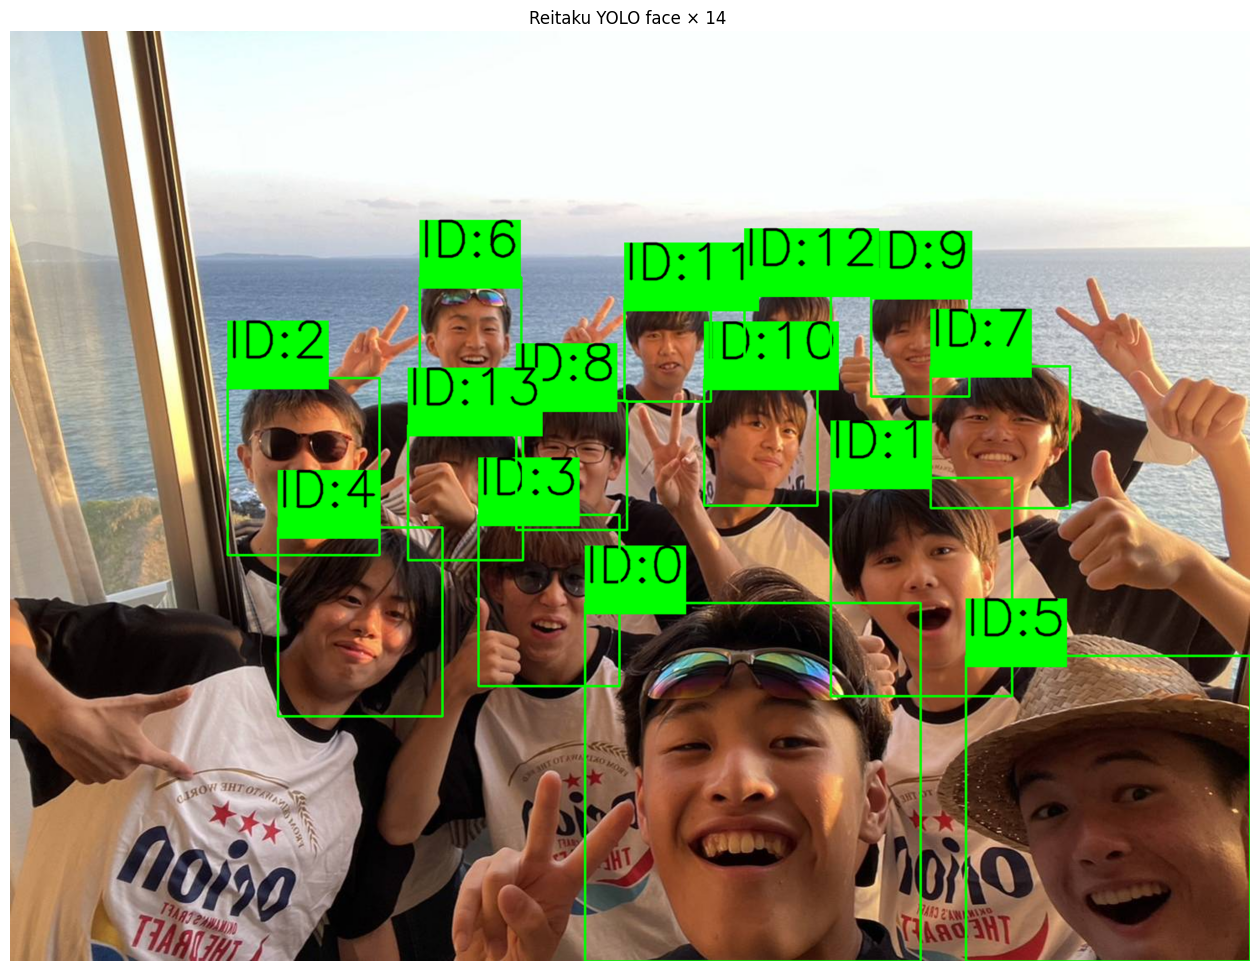

In [30]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 画像とモデルの準備
image_path = Path("okinawa2.jpg")
model_path = Path("yolov8m-face.pt")

# YOLO で高解像度推論（imgsz を指定）
model = YOLO(model_path)
result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

# 画像読み込みと基本情報
annotated = cv2.imread(str(image_path))
h_img, w_img = annotated.shape[:2]
color = (0,255,0)
font_scale = 2
thickness = 2

# 検出結果を描画（バッファ付き）
for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
    x1,y1,x2,y2 = map(int, box)
    w = x2 - x1; h = y2 - y1
    pad = int(max(w,h) * 0.2)  # バッファ 20%
    x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
    cv2.rectangle(annotated, (x1p,y1p), (x2p,y2p), color, thickness)
    label = f"ID:{idx}"
    (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    y_label = y1p-6 if y1p-6>h_label else y1p+h_label+6
    cv2.rectangle(annotated, (x1p, y_label-h_label-baseline), (x1p+w_label, y_label+baseline), color, -1)
    cv2.putText(annotated, label, (x1p, y_label-baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness, cv2.LINE_AA)

# 高解像度で保存（アップスケールして保存）
output_path = Path("reitaku_yolo_faces.jpg")
annot_up = cv2.resize(annotated, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
cv2.imwrite(str(output_path), annot_up)
print(f"検出された顔の数: {len(result.boxes)} faces")
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(annot_up, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Reitaku YOLO face × {len(result.boxes)} ')
plt.show()

ぼかし画像を保存しました: okinawa1_blur_faces.jpg 


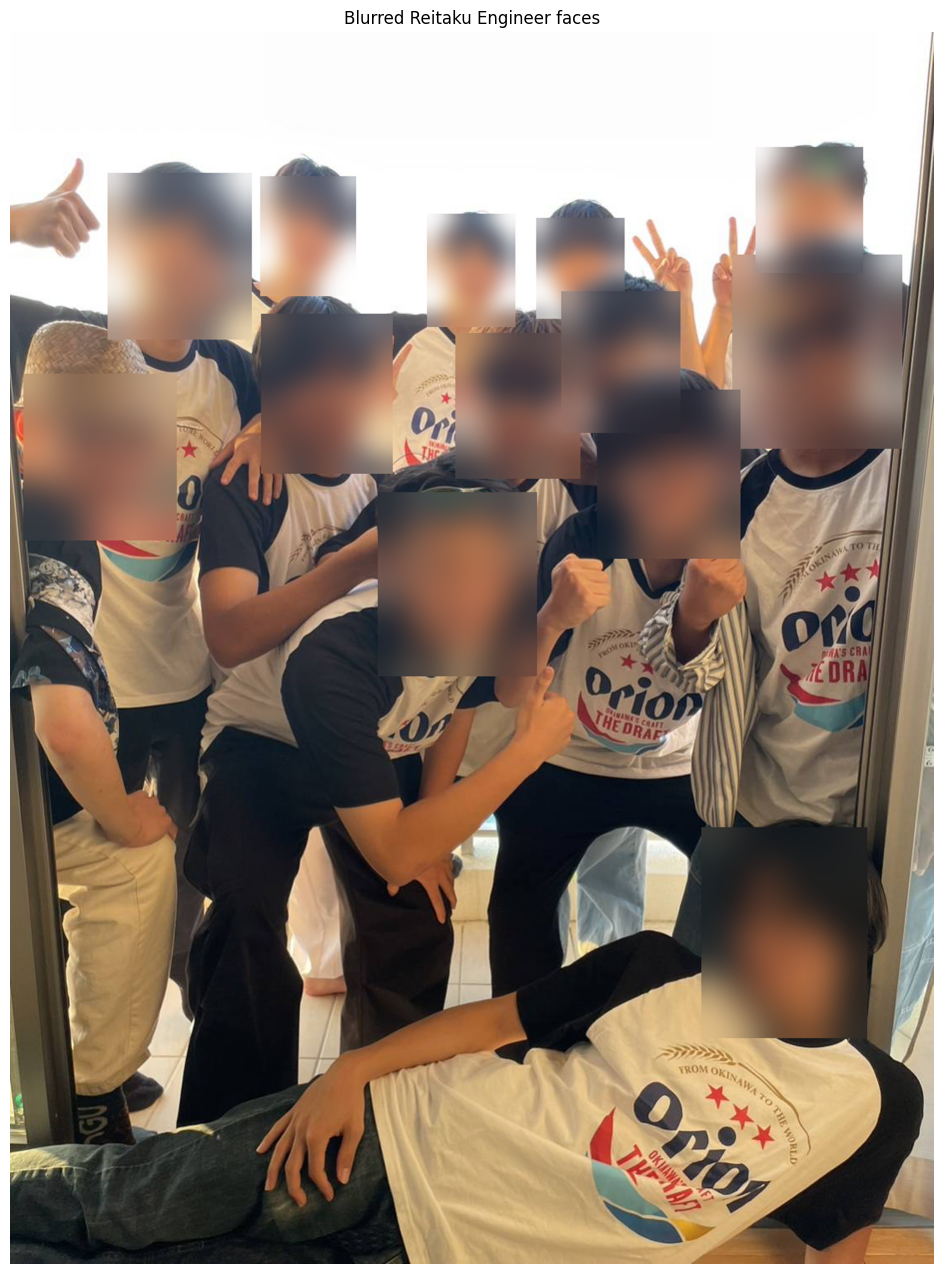

In [31]:
# 顔領域を強くぼかして高解像度で保存（関数化）：blur_faces(image_path) を定義・実行
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def blur_faces(image_path):
    """
    blur_faces(image_path): YOLO で検出して顔領域を強くぼかす関数。
    引数は image_path のみ（文字列または Path）。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    # 画像を読み込む
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    out = img.copy()  # 出力用にコピー

    # 検出された顔ごとに処理
    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        if x2 <= x1 or y2 <= y1:
            continue  # 異常なボックスはスキップ
        w = x2 - x1
        h = y2 - y1
        pad = int(max(w, h) * 0.2)  # 顔の周囲に20%のバッファを追加
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad)
        y2p = min(h_img, y2 + pad)
        face = out[y1p:y2p, x1p:x2p]  # 顔領域を切り出し
        if face.size == 0:
            continue  # 領域が空ならスキップ
        # ブラーのカーネルサイズを決定（顔サイズに応じて大きめに設定）
        k = max(5, min(face.shape[0], face.shape[1]) // 2)
        if k % 2 == 0:
            k += 1  # カーネルサイズは奇数にする必要あり
        # 2回ガウシアンブラーをかけて強くぼかす
        face_blur = cv2.GaussianBlur(face, (k, k), 0)
        face_blur = cv2.GaussianBlur(face_blur, (k, k), 0)
        out[y1p:y2p, x1p:x2p] = face_blur  # ぼかした顔を元画像に貼り付け

    # 画像全体を2倍にアップスケールして高解像度で保存
    up = cv2.resize(out, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
    output_path = image_path.with_name(image_path.stem + '_blur_faces.jpg')
    cv2.imwrite(str(output_path), up)
    print(f'ぼかし画像を保存しました: {output_path} ')

    # 結果を表示
    plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(up, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Blurred Reitaku Engineer faces')
    plt.show()

# 関数を実行（reitaku.jpg を引数として渡す）
blur_faces('okinawa1.jpg')

置換画像を保存しました: okinawa1_smile_replace.jpg 


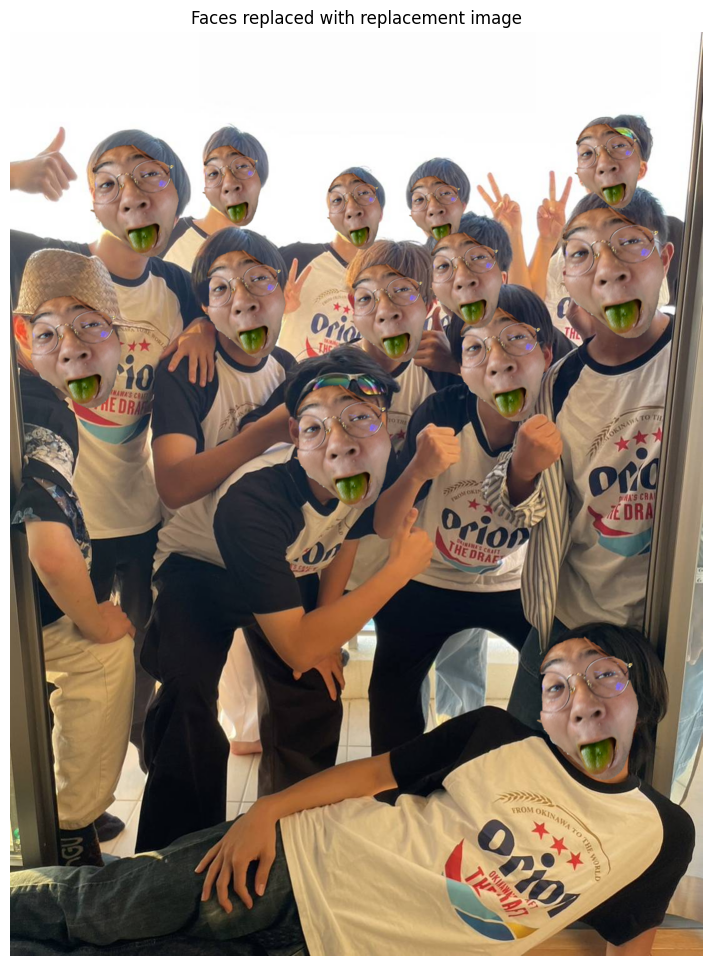

In [40]:
# 顔領域を画像で置き換えて高解像度で保存（関数化）：replace_faces(image_path, replace_image_path) を定義・実行
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def replace_faces(image_path, replace_image_path):
    """
    replace_faces(image_path, replace_image_path): YOLO で検出して検出領域を指定画像で置換する関数。
    引数は image_path と replace_image_path（どちらも文字列または Path）。
    """
    image_path = Path(image_path)
    replace_image_path = Path(replace_image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    # 置換に使う画像を確認（アルファチャネル対応 PNG を想定）
    if not replace_image_path.exists():
        raise FileNotFoundError(f'{replace_image_path} が作業ディレクトリに見つかりません')
    repl = cv2.imread(str(replace_image_path), cv2.IMREAD_UNCHANGED)
    if repl is None:
        raise FileNotFoundError(f'Failed to read replacement image: {replace_image_path}')

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    out = img.copy()

    for box in result.boxes.xyxy.cpu().numpy():
        # 検出ボックスを整数化
        x1, y1, x2, y2 = map(int, box)
        if x2 <= x1 or y2 <= y1:
            continue

        # 顔サイズとバッファ（20%）を計算
        w = x2 - x1
        h = y2 - y1
        pad = int(max(w, h) * 0.2)
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad)
        y2p = min(h_img, y2 + pad)
        w_p = max(1, x2p - x1p)
        h_p = max(1, y2p - y1p)

        # 置き換え画像が空でないか確認
        if repl.shape[1] == 0 or repl.shape[0] == 0:
            continue

        # 顔領域（バッファ込み）の大きさにリサイズ
        repl_resized = cv2.resize(repl, (w_p, h_p), interpolation=cv2.INTER_AREA)

        # アルファチャネルがある場合はブレンド
        if repl_resized.shape[2] == 4:
            alpha = repl_resized[:, :, 3] / 255.0
            for c in range(3):
                out[y1p:y2p, x1p:x2p, c] = (
                    alpha * repl_resized[:, :, c] +
                    (1 - alpha) * out[y1p:y2p, x1p:x2p, c]
                )
        else:
            out[y1p:y2p, x1p:x2p] = repl_resized[:, :, :3]

    # 仕上げに 2 倍スケールで高解像度保存（CUBIC で滑らかに拡大）
    up = cv2.resize(out, (w_img * 2, h_img * 2), interpolation=cv2.INTER_CUBIC)
    output_path = image_path.with_name(image_path.stem + '_smile_replace.jpg')
    cv2.imwrite(str(output_path), up)
    print(f'置換画像を保存しました: {output_path} ')

    # プレビュー表示
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(up, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Faces replaced with replacement image')
    plt.show()

# 関数を実行（reitaku.jpg を引数として渡す。置換画像は smile.png）
replace_faces('okinawa1.jpg', 'dekaburtu1.png')

コラージュを保存しました: okinawa2_faces_collage.jpg (faces: 14)


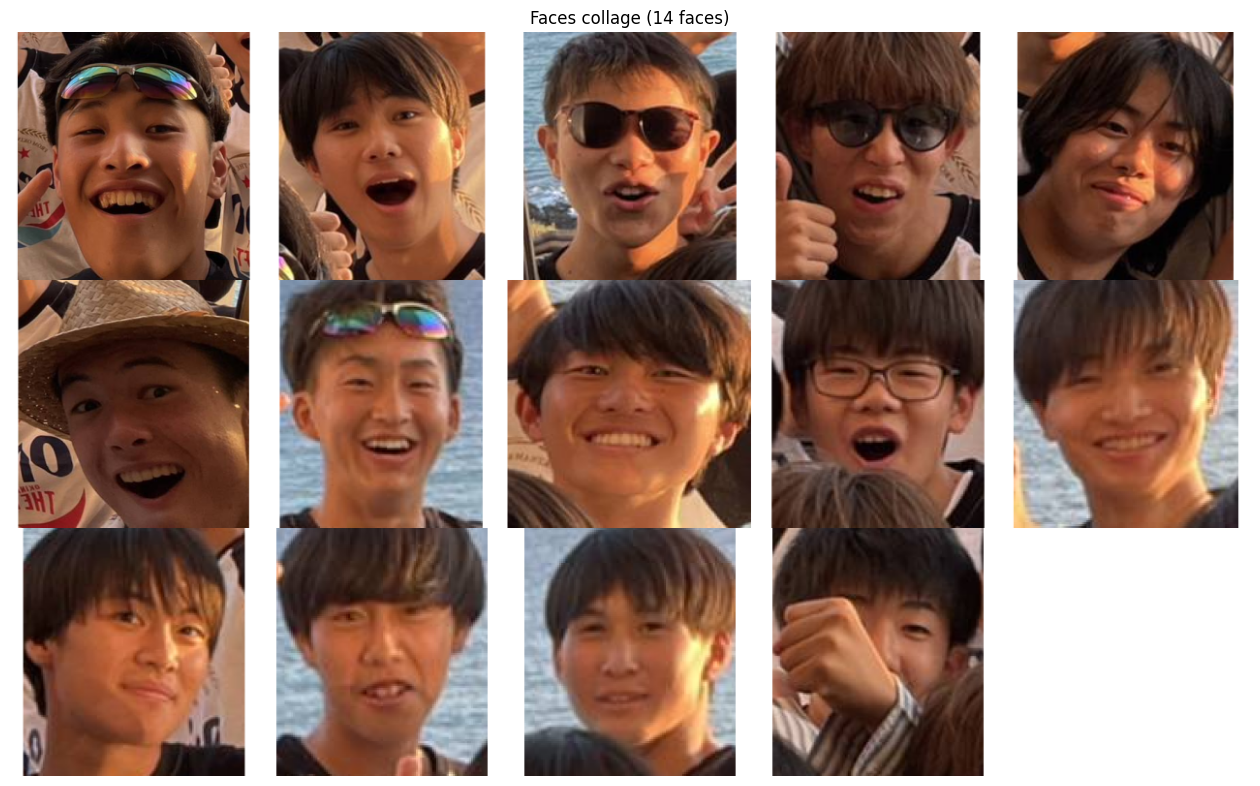

In [35]:
# 切り出した顔のコラージュを高解像度で作成（関数化）：collage_faces(image_path) を定義・実行
import cv2
import numpy as np
from math import ceil
from pathlib import Path
import matplotlib.pyplot as plt

def collage_faces(image_path):
    """
    collage_faces(image_path): YOLO で検出して顔を切り出し、コラージュを作成する関数。
    引数は image_path のみ（文字列または Path）。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    faces = []
    tile = 256

    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        w = x2 - x1; h = y2 - y1
        pad = int(max(w, h) * 0.2)
        x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
        if x2p <= x1p or y2p <= y1p:
            continue
        crop = img[y1p:y2p, x1p:x2p]
        h_c, w_c = crop.shape[:2]
        size = max(h_c, w_c)
        square = np.full((size, size, 3), 255, dtype=np.uint8)
        y_off = (size - h_c)//2; x_off = (size - w_c)//2
        square[y_off:y_off+h_c, x_off:x_off+w_c] = crop
        faces.append(cv2.resize(square, (tile, tile), interpolation=cv2.INTER_AREA))

    if len(faces) == 0:
        print('コラージュ用の顔が見つかりません')
        return None

    cols = min(5, len(faces))
    rows = ceil(len(faces) / cols)
    canvas = np.full((rows*tile, cols*tile, 3), 255, dtype=np.uint8)
    for idx, f in enumerate(faces):
        r = idx // cols; c = idx % cols
        canvas[r*tile:(r+1)*tile, c*tile:(c+1)*tile] = f

    output_path = image_path.with_name(image_path.stem + '_faces_collage.jpg')
    cv2.imwrite(str(output_path), canvas)
    print(f'コラージュを保存しました: {output_path} (faces: {len(faces)})')
    plt.figure(figsize=(16,12))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Faces collage ({len(faces)} faces)')
    plt.show()

# 関数を実行（reitaku.jpg を引数として渡す）
collage_faces('okinawa2.jpg')